In [4]:
%env KERAS_BACKEND = tensorflow
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

env: KERAS_BACKEND=tensorflow


In [74]:
from ipywidgets import interact, FloatSlider, BoundedIntText

# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

In [6]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [7]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

In [8]:
x = Input(shape=(784, ))

# encoder

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

# decoder

dec_1 = Dense(100, activation='sigmoid')
dec_2 = Dense(784, activation='sigmoid')

out = dec_2(dec_1(h))



In [9]:
autoencoder = Model(x, out)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.compile(loss='mse', optimizer=Adam())

In [11]:
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128)

Epoch 1/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.0737
Epoch 2/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0661
Epoch 3/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0623
Epoch 4/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.0606
Epoch 5/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.0589
Epoch 6/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0570
Epoch 7/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.0560
Epoch 8/50
60000/60000 [==============================] - 4s 62us/step - loss: 0.0554
Epoch 9/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0550
Epoch 10/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.0548
Epoch 11/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0546
Epoch 12/50
60000/60000 [===========================

In [12]:
Encoder = Model(x, h)
Encoder.summary()

# 錯誤寫法
# Decoder = Model(h, out)
#
# 正確寫法
h_in = Input(shape=(2,))
Decoder = Model(h_in, dec_2(dec_1(h_in)))
Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_

In [13]:
x_train[0:3].shape

(3, 784)

In [14]:
index = np.random.randint(x_train.shape[0])
print ("第 %d 張圖的 latent value為 %s" %(index, Encoder.predict(x_train[index:index+1])))

第 24 張圖的 latent value為 [[0.17927398 0.25943625]]


## 取3000點作圖

In [15]:
x_test.shape

(10000, 784)

In [16]:
indices = np.random.randint(x_test.shape[0], size=3000)

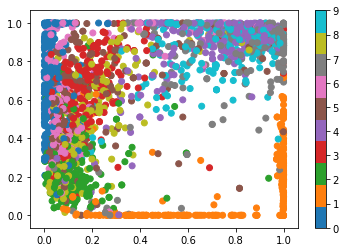

In [17]:
latents = Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c = y_test0[indices], cmap='tab10')
plt.colorbar()
plt.show()

In [18]:
n = 15
digit = 28

figure = np.zeros((digit*n, digit*n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digits = x_decoded[0].reshape(digit, digit)
        figure[i*digit:(i+1)*digit, j*digit:(j+1)*digit] = digits

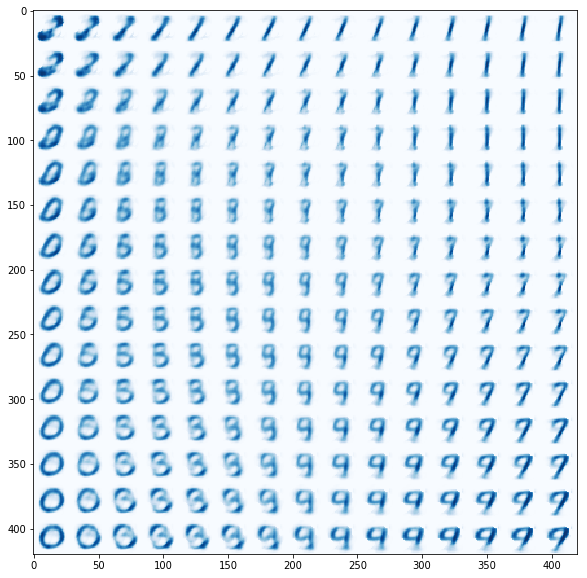

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Blues')
plt.show()

## VAE(variational autoencoder)

### 若我們希望將一常態分佈之latent value區域都轉成同一個值，可將 encoder output化為 (mean, log varance)，如此可增加其準確度。

In [20]:
VAE_x = Input(shape=(784, ))

# encoder

VAE_enc_1 = Dense(100, activation='sigmoid')

h_mean = Dense(2)
h_logvar = Dense(2)

# decoder

VAE_dec_1 = Dense(100, activation='sigmoid')
VAE_dec_2 = Dense(784, activation='sigmoid')

out = dec_2(dec_1(h))


In [21]:
enc_x = VAE_enc_1(x)
z_mean = h_mean(enc_x)
z_logvar = h_logvar(enc_x)

#### 定義抽樣函數並透過 Lambda 將其轉換成 Keras layer。<br>透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [22]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [23]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_logvar])

In [24]:
dec_x = VAE_dec_1(z)
VAE_out = VAE_dec_2(dec_x)

In [25]:
VAE = Model(x, VAE_out)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

#### VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，<br><br>因此，我們在此直接建立訓練 VAE 時的 loss 函數。<br><br>若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

#### 同學有興趣可以證明下面關於 KL 散度在兩個常態分配上的性質：若 $p\sim N(\mu_1,\sigma_1^2)$, $q\sim N(\mu_2,\sigma_2^2)$，則 $KL(p, q) = \log\dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}$

In [26]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=-1)
    return recovery_loss + kl_loss

In [27]:
VAE.compile(loss=vae_loss, optimizer=Adam())


In [28]:
VAE.fit(x_train, x_train, batch_size=128, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 6s 105us/step - loss: 220.9809
Epoch 2/100
60000/60000 [==============================] - 5s 86us/step - loss: 187.2412
Epoch 3/100
60000/60000 [==============================] - 5s 86us/step - loss: 183.0525
Epoch 4/100
60000/60000 [==============================] - 5s 86us/step - loss: 181.7833
Epoch 5/100
60000/60000 [==============================] - 5s 85us/step - loss: 181.1326
Epoch 6/100
60000/60000 [==============================] - 5s 88us/step - loss: 180.4518
Epoch 7/100
60000/60000 [==============================] - 5s 89us/step - loss: 179.9160
Epoch 8/100
60000/60000 [==============================] - 5s 91us/step - loss: 179.5579
Epoch 9/100
60000/60000 [==============================] - 6s 92us/step - loss: 178.8529
Epoch 10/100
60000/60000 [==============================] - 5s 88us/step - loss: 178.1449
Epoch 11/100
60000/60000 [==============================] - 5s 88us/step - loss: 177.0836
Epoch 12/100
60000

60000/60000 [==============================] - 5s 86us/step - loss: 148.9142
Epoch 92/100
60000/60000 [==============================] - 5s 85us/step - loss: 149.0527
Epoch 93/100
60000/60000 [==============================] - 5s 85us/step - loss: 148.8090
Epoch 94/100
60000/60000 [==============================] - 5s 86us/step - loss: 148.7212
Epoch 95/100
60000/60000 [==============================] - 5s 86us/step - loss: 148.6814
Epoch 96/100
60000/60000 [==============================] - 5s 86us/step - loss: 148.7049
Epoch 97/100
60000/60000 [==============================] - 5s 86us/step - loss: 148.5958
Epoch 98/100
60000/60000 [==============================] - 5s 86us/step - loss: 148.5937
Epoch 99/100
60000/60000 [==============================] - 5s 88us/step - loss: 148.3884
Epoch 100/100
60000/60000 [==============================] - 5s 86us/step - loss: 148.3324


### Visualize VAE results

In [29]:
VAE_encoder = Model(x, z_mean)
VAE_encoder.summary()

h_in = Input(shape=(2,))
VAE_decoder = Model(h_in, VAE_dec_2(VAE_dec_1(h_in)))
VAE_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_

In [30]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_encoder.predict(x_train[idx: idx+1])))

第 49268 圖的 latent 表示為 [[-0.16950889 -3.612874  ]]


In [31]:
# indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_encoder.predict(x_test[indices])

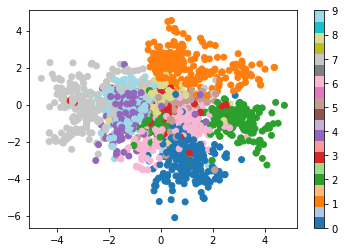

In [32]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [33]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [34]:
VAE_grid_x = np.linspace(-4+0.05, 4-0.05, n)
VAE_grid_y = np.linspace(-4+0.05, 4-0.05, n)
VAE_fig = np.zeros((digit*n, digit*n))
for i, yi in enumerate(VAE_grid_x):
    for j, xi in enumerate(VAE_grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_decoder.predict(z_sample)
        digits = x_decoded[0].reshape(digit, digit)
        VAE_fig[i*digit:(i+1)*digit, j*digit:(j+1)*digit] = normalized(digits)


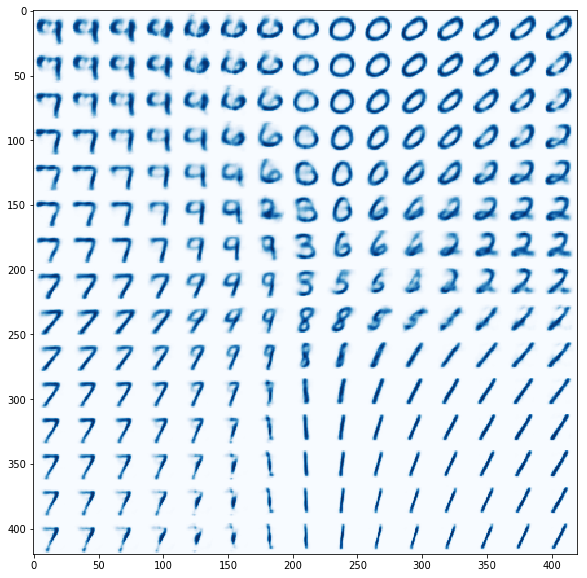

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_fig, cmap="Blues")
plt.show()

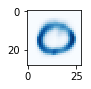

In [36]:
test = np.array([[0, -3.1]])
testpic = VAE_decoder.predict(test)
test_digits = testpic[0].reshape(digit, digit)
fig = normalized(test_digits)
plt.figure(figsize=(1,1))
plt.imshow(fig, cmap='Blues')

## 動態比較

In [63]:
def inBetween(t, idx_1, idx_2):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [64]:
#idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
#data_0 = x_train0[idx_1]
#data_1 = x_train0[idx_2]

## 讓互動功能更多：interact 加上兩個 bounded int text讓使用者自行選擇想看的兩個數字

In [84]:
def toggle():
    interact(inBetween, t=FloatSlider(value=0.5, 
                                      min=0, 
                                      max=1.0,
                                      step=0.02,), idx_1=BoundedIntText(max=59999, min=0, value=np.random.randint(0, 59999)), idx_2=BoundedIntText(max=59999, min=0, value=np.random.randint(0, 59999)))

In [85]:
toggle()

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), BoundedIntText(value=48388,…